In [1]:
# External
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import importlib
import traceback

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
module_path = os.path.abspath(os.path.join('..'))
module_path, os.getcwd()

('D:\\coding\\dam\\hw230k\\hw2', 'D:\\coding\\dam\\hw230k\\hw2\\code')

In [3]:
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)
if module_path != os.getcwd():
    print(f"""
Changing directory from:
    {os.getcwd()} 
to: 
    {module_path}
"""
         )
    os.chdir(module_path)

Adding D:\coding\dam\hw230k\hw2 to sys.path

Changing directory from:
    D:\coding\dam\hw230k\hw2\code 
to: 
    D:\coding\dam\hw230k\hw2



In [4]:
sys.path

['D:\\coding\\dam\\hw230k\\hw2\\code',
 'D:\\coding\\springboard\\capstone\\springboard-capstone-project\\app',
 'D:\\miniconda\\envs\\230k\\python39.zip',
 'D:\\miniconda\\envs\\230k\\DLLs',
 'D:\\miniconda\\envs\\230k\\lib',
 'D:\\miniconda\\envs\\230k',
 '',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages\\locket-0.2.1-py3.9.egg',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages\\win32',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages\\win32\\lib',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages\\Pythonwin',
 'D:\\miniconda\\envs\\230k\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\nicol\\.ipython',
 'D:\\coding\\dam\\hw230k\\hw2']

In [5]:
os.getcwd()

'D:\\coding\\dam\\hw230k\\hw2'

In [6]:
from utils import sql_manager

In [7]:
importlib.reload(sql_manager)

<module 'utils.sql_manager' from 'D:\\coding\\dam\\hw230k\\hw2\\code\\utils\\sql_manager.py'>

In [8]:
sql = sql_manager.ManagerSQL()

D:\coding\dam\hw230k\hw2


## Create table

Too much data to handle on csv files. I will load to a postgres database.

In [9]:
query = """
CREATE TABLE IF NOT EXISTS crsp_returns
(
    permno int NOT NULL,
    date timestamp without time zone NOT NULL,
    ticker varchar(20),
    prc float NOT NULL,
    vol int,
    ret float NOT NULL,
    shrout int NOT NULL,
    PRIMARY KEY (permno, date)
);

CREATE INDEX IF NOT EXISTS idx_date ON crsp_returns(date);

"""
sql.query(query)

In [10]:
query = """
CREATE TABLE IF NOT EXISTS wrds_ratios
(
    permno int NOT NULL,
    adate timestamp without time zone,
    qdate timestamp without time zone NOT NULL,
    public_date timestamp without time zone NOT NULL,
    bm float,
    divyield float,
    pcf float,
    roa float,
    roe float,
    PRIMARY KEY (permno, qdate, public_date)
);
"""
sql.query(query)

In [47]:
query = """
CREATE TABLE IF NOT EXISTS crsp_monthly_returns
(
    permno int NOT NULL,
    date timestamp without time zone NOT NULL,
    ticker varchar(20),
    bm float,
    size int,
    ret float NOT NULL,
    volume int,
    PRIMARY KEY (permno, date)
);

CREATE INDEX IF NOT EXISTS crsp_monthly_returns_idx_date ON crsp_monthly_returns(date);

"""
sql.query(query)

In [56]:
query = """
CREATE TABLE IF NOT EXISTS crsp_returns_factors
(
    permno int NOT NULL,
    date timestamp without time zone NOT NULL,
    ticker varchar(20),
    logret float NOT NULL,
    beta float,
    bm float,
    size int,
    mom float,
    vol float
    PRIMARY KEY (permno, date)
);

CREATE INDEX IF NOT EXISTS idx_date ON crsp_returns_factors(date);

"""
sql.query(query)

In [153]:
query = """
CREATE TABLE IF NOT EXISTS crsp_monthly_returns_factors
(
    permno int NOT NULL,
    date timestamp without time zone NOT NULL,
    ticker varchar(20),
    logret float NOT NULL,
    logret_1m float NOT NULL,
    beta float,
    bm float,
    size int,
    mom float,
    vol float,
    PRIMARY KEY (permno, date)
);

CREATE INDEX IF NOT EXISTS crsp_monthly_returns_factors_idx_date ON crsp_monthly_returns_factors(date);

"""
#sql.query(query)

## Upload data

Sources:
- CRSP Daily Stock:  
https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/
- Financial Ratios Industry Level by WRDS:  
https://wrds-www.wharton.upenn.edu/pages/get-data/financial-ratios-suite-wrds/financial-ratios/financial-ratios-firm-level-by-wrds-beta/
- S&P 500:  
https://wrds-www.wharton.upenn.edu/pages/support/support-articles/crsp/index-and-deciles/sp-500-daily-sprtrn-vs-daily-vwretx/


Data is given filtered to students. Each cross-sectional portfolio will use the 500 largest companies. A ranking will be performed, but all companies that were in the top 500 at any point will have all there history. This introduces a bias which students will have to be careful with.

88,354,626 data points in crsp_returns after applying basic filters to the original data.

#### CRSP Daily Stock

In [ ]:
crsp_prices_filename = "data/crsp_stock_daily.csv"
wrds_ratios_filename = "data/crsp_stock_daily.csv"

In [ ]:
cols = ['PERMNO', 'TICKER', 'date', 'PRC', 'VOL', 'RET', 'SHROUT']

In [ ]:
def process_year(year, chunk):
    chunk_year = chunk.loc[years == year]
    filename = f"data/chunks/crsp_stock_daily_{year}.csv"
    if not os.path.isfile(filename):
        chunk_year.to_csv(filename, index=False)
    else:
        data = pd.read_csv(filename)
        data = pd.concat((data, chunk_year))
        data = data.drop_duplicates()
        data.to_csv(filename, index=False)

In [ ]:
# If ran, the next cell takes around 4 hours to run. It finishes with cnt equal 90 (printed)
if False:
    chunksize = 1e6
    cnt = 0
    #sql.clean_table('crsp_returns')
    for chunk in pd.read_csv(crsp_prices_filename, 
                             usecols=cols,
                             chunksize=chunksize, 
                             low_memory=False):
        chunk.columns = [col.lower() for col in chunk.columns]
        chunk['ret'] = pd.to_numeric(chunk.ret, errors='coerce')
        bool_has_relevant_data = ~(chunk.ret.isnull() | chunk.prc.isnull() | chunk.shrout.isnull())
        chunk = chunk.loc[bool_has_relevant_data]
        #display(chunk.head())
        dt_ds = pd.to_datetime(chunk.date, format="%Y%m%d")
        chunk['date'] = dt_ds.dt.date
        chunk = chunk.drop_duplicates(['permno', 'date'])
        print(cnt, end="\r")
        cnt += 1
        sql.upload_df_chunks('crsp_returns', chunk, chunk_size=100)

#### WRDS financial ratios

In [160]:
#sql.clean_table('wrds_ratios')

In [129]:
wrds_ratios = pd.read_csv("data/wrds_fin_ratio.csv")

In [131]:
wrds_ratios.shape

(2826775, 76)

In [130]:
wrds_ratios.head()

,gvkey,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,cusip
0,1000,25881,19691231.0,19700930.0,19710131,10.950,0.427,1.761,NaN,NaN,...,11.215,0.0,0.0,0.0,-0.530,2.340,NaN,NaN,NaN,NaN
1,1000,25881,19701231.0,19701231.0,19710228,35.407,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,-0.021,2.801,NaN,NaN,AE,00003210
2,1000,25881,19701231.0,19701231.0,19710331,31.031,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,-0.021,2.455,NaN,NaN,AE,00003210
3,1000,25881,19701231.0,19701231.0,19710430,34.214,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,-0.021,2.707,NaN,NaN,AE,00003210
4,1000,25881,19701231.0,19710331.0,19710531,11.307,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,-0.021,2.172,NaN,NaN,AE,00003210


In [132]:
wrds_ratios.columns

Index(['gvkey', 'permno', 'adate', 'qdate', 'public_date', 'CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'TICKER', 'cusip'],
  

In [133]:
cols = ['permno', 'adate', 'qdate', 'public_date', 'bm', 'divyield', 'pcf', 'roa', 'roe']
wrds_ratios = wrds_ratios[cols]

In [134]:
wrds_ratios['adate'] = pd.to_datetime(wrds_ratios.adate.map(lambda x: str(x)[:8]), format="%Y%m%d")
wrds_ratios['qdate'] = pd.to_datetime(wrds_ratios.qdate, format="%Y%m%d")
wrds_ratios['public_date'] = pd.to_datetime(wrds_ratios.public_date, format="%Y%m%d")

In [135]:
wrds_ratios['divyield'] = pd.to_numeric(wrds_ratios.divyield, errors='coerce')

In [139]:
wrds_ratios['rnk'] = wrds_ratios.groupby(['permno', 'qdate'])['public_date'].rank(method='first')

In [142]:
wrds_ratios = wrds_ratios.sort_values(['permno', 'qdate', 'public_date'])

In [143]:
wrds_ratios.head()

,permno,adate,qdate,public_date,bm,divyield,pcf,roa,roe,rnk
1582893,10000,1985-10-31,1986-01-31,1986-03-31,0.044,NaN,-31.464,-0.599,NaN,1.0
1582894,10000,1985-10-31,1986-01-31,1986-04-30,0.044,NaN,-29.233,-0.599,NaN,2.0
1582895,10000,1985-10-31,1986-01-31,1986-05-31,0.044,NaN,-22.724,-0.599,NaN,3.0
1582896,10000,1985-10-31,1986-04-30,1986-06-30,0.039,NaN,-13.320,-0.826,-0.209,1.0
1582897,10000,1985-10-31,1986-04-30,1986-07-31,0.039,NaN,-12.243,-0.826,-0.209,2.0


In [145]:
wrds_ratios = wrds_ratios.loc[wrds_ratios.rnk == 1]

In [146]:
wrds_ratios.head()

,permno,adate,qdate,public_date,bm,divyield,pcf,roa,roe,rnk
1582893,10000,1985-10-31,1986-01-31,1986-03-31,0.044,NaN,-31.464,-0.599,NaN,1.0
1582896,10000,1985-10-31,1986-04-30,1986-06-30,0.039,NaN,-13.320,-0.826,-0.209,1.0
1582899,10000,1985-10-31,1986-07-31,1986-09-30,0.027,NaN,-4.220,-0.792,-0.619,1.0
1582902,10000,1986-10-31,1986-10-31,1986-12-31,0.145,NaN,-1.469,-0.413,NaN,1.0
1582905,10000,1986-10-31,1987-01-31,1987-03-31,0.145,NaN,-0.721,-0.413,-1.477,1.0


In [157]:
wrds_ratios = wrds_ratios.dropna(subset=['permno', 'qdate', 'public_date', 'bm'])

In [158]:
wrds_ratios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862674 entries, 1582893 to 2803609
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   permno       862674 non-null  int64         
 1   adate        858254 non-null  datetime64[ns]
 2   qdate        862674 non-null  datetime64[ns]
 3   public_date  862674 non-null  datetime64[ns]
 4   bm           862674 non-null  float64       
 5   divyield     0 non-null       float64       
 6   pcf          845825 non-null  float64       
 7   roa          843940 non-null  float64       
 8   roe          840216 non-null  float64       
 9   rnk          862674 non-null  float64       
dtypes: datetime64[ns](3), float64(6), int64(1)
memory usage: 72.4 MB


In [161]:
sql.upload_df_chunks('wrds_ratios', wrds_ratios[cols], chunk_size=100)

## Process data

#### Filter largest 2000 companies returns and merge Book to Market

In [41]:
query = f"select distinct date from crsp_returns"
bdates = sql.select_query(query)
bdates = bdates.date.sort_values()
eom_dates = bdates.groupby([bdates.dt.year, bdates.dt.month]).max().reset_index(drop=True)
eom_dates.head()

0   1960-01-29
1   1960-02-29
2   1960-03-31
3   1960-04-29
4   1960-05-31
Name: date, dtype: datetime64[ns]

In [42]:
query = """
select permno, qdate, public_date, bm
from (
    select permno, qdate, public_date, bm, dense_rank() over (partition by qdate order by public_date) rnk
    from wrds_ratios
    where bm is not NULL
) a
where rnk = 1
"""
ratios = sql.select_query(query)
ratios.head()

,permno,qdate,public_date,bm
0,27457,1969-07-31,1970-01-31,0.836
1,27983,1969-09-30,1970-01-31,0.089
2,27422,1969-09-30,1970-01-31,0.607
3,25582,1969-09-30,1970-01-31,0.356
4,26075,1969-09-30,1970-01-31,0.421


In [43]:
ratios.shape

(854563, 4)

In [45]:
eom_dates = eom_dates.loc[eom_dates >= ratios.public_date.min()]
eom_dates.head()

121   1970-02-27
122   1970-03-31
123   1970-04-30
124   1970-05-29
125   1970-06-30
Name: date, dtype: datetime64[ns]

In [48]:
def process_size(date, n_companies=2000):
    """
        - Include Book to Market factor
        - Compute Size factor
        - Filter the largest 500 companies
        - Upload to database
    """
    
    # crsp_returns for the date
    date_str = date.strftime('%Y-%m-%d')
    query = f"select * from crsp_returns where date = '{date_str}'"
    ret_date = sql.select_query(query)

    # wrds_ratios for the date
    ratios_date = ratios.loc[ratios.public_date <= date]
    ratios_date = ratios_date.loc[ratios_date.groupby('permno')['public_date'].idxmax()]

    # Combine information
    df = ret_date.merge(ratios_date[['permno', 'bm']], how='inner', left_on='permno', right_on='permno')
    df['size'] = np.absolute(df['prc'].multiply(df['shrout'])).round(0).astype(int)

    # Filter largest 500 companies
    df = df.sort_values('size', ascending=False).reset_index(drop=True).iloc[:n_companies]

    # Format
    df.rename(columns={'vol': 'volume'}, inplace=True)
    cols = ['permno', 'date', 'ticker', 'bm', 'size', 'ret', 'volume']
    df = df[cols]    

    # Upload
    sql.upload_df_chunks('crsp_monthly_returns', df, chunk_size=100)

In [50]:
if False:
    sql.clean_table('crsp_monthly_returns')
    for date in eom_dates:
        print(date, end="\r")
        process_size(date)

#### Compute other factors

Beta, Momentum, Volatility, BAB

In [387]:
date = datetime(1974, 8, 30)

In [388]:
date_str = date.strftime('%Y-%m-%d')
query = f"select * from crsp_monthly_returns where date = '{date_str}'"
ret_date = sql.select_query(query)

In [389]:
ret_date['logret'] = np.log(1 + ret_date.ret)

In [390]:
ret_date

,permno,date,ticker,bm,size,ret,volume,logret
0,59395,1974-08-30,None,0.913,66656,-0.007353,NaN,-0.007380
1,12490,1974-08-30,IBM,0.263,27881088,0.017219,69400.0,0.017072
2,10401,1974-08-30,T,1.094,23599570,0.024096,129800.0,0.023810
3,11850,1974-08-30,XON,0.778,15055056,0.017013,45900.0,0.016870
4,11754,1974-08-30,EK,0.172,12943793,0.054276,102600.0,0.052854
...,...,...,...,...,...,...,...,...
1995,43887,1974-08-30,MEM,1.531,7216,0.040816,3600.0,0.040005
1996,28716,1974-08-30,AO,1.362,7214,0.200000,1100.0,0.182322
1997,35430,1974-08-30,PNU,2.269,7200,-0.040000,300.0,-0.040822
1998,52513,1974-08-30,IFN,2.210,7194,0.000000,900.0,0.000000


In [391]:
# Get the time series from 5 years ago until now of all 500 companies
# Momentum: cumulative log returns from 12 months to 1 month ago
# Volatility: volatility of log returns
# Beta: coefficient of regressing S&P returns with stock returns

In [392]:
date_5y = date - relativedelta(years=5)
date_12m = date - relativedelta(months=12)
date_1m = date - relativedelta(months=1)
date_f1m = date + relativedelta(months=1)

In [393]:
date, date_1m, date_12m, date_5y

(datetime.datetime(1974, 8, 30, 0, 0),
 datetime.datetime(1974, 7, 30, 0, 0),
 datetime.datetime(1973, 8, 30, 0, 0),
 datetime.datetime(1969, 8, 30, 0, 0))

In [394]:
date_str = date.strftime('%Y-%m-%d')
date_f1m_str = date_f1m.strftime('%Y-%m-%d')
date_5y_str = date_5y.strftime('%Y-%m-%d')
query = rf"""
select * from crsp_returns 
where date between '{date_5y_str}' and '{date_f1m_str}'
      and permno in ({','.join([str(permno) for permno in ret_date.permno])})
"""
ret_past = sql.select_query(query)

In [395]:
ret_past['logret'] = np.log(1 + ret_past.ret)

In [396]:
ret_past.head()

,permno,date,ticker,prc,vol,ret,shrout,logret
0,10006,1969-09-02,ACF,45.000,1100.0,0.000000,5641,0.000000
1,10006,1969-09-03,ACF,45.250,3200.0,0.005556,5641,0.005541
2,10006,1969-09-04,ACF,45.250,2900.0,0.000000,5641,0.000000
3,10006,1969-09-05,ACF,45.000,3400.0,-0.005525,5641,-0.005540
4,10006,1969-09-08,ACF,44.875,2000.0,-0.002778,5641,-0.002782


In [397]:
ret_past.date.min()

Timestamp('1969-09-02 00:00:00')

In [398]:
ret_past.date.max()

Timestamp('1974-09-30 00:00:00')

##### Momentum

In [399]:
ret_past.head()

,permno,date,ticker,prc,vol,ret,shrout,logret
0,10006,1969-09-02,ACF,45.000,1100.0,0.000000,5641,0.000000
1,10006,1969-09-03,ACF,45.250,3200.0,0.005556,5641,0.005541
2,10006,1969-09-04,ACF,45.250,2900.0,0.000000,5641,0.000000
3,10006,1969-09-05,ACF,45.000,3400.0,-0.005525,5641,-0.005540
4,10006,1969-09-08,ACF,44.875,2000.0,-0.002778,5641,-0.002782


In [400]:
def compute_factor(name, target_col, date_start, date_end, operation, tolerance_days):
    factor_past = (ret_past
                   .loc[ret_past.date.between(date_start, date_end)]
                   .groupby('permno').agg({target_col: [operation, len]})
                  )
    factor = factor_past.loc[factor_past.iloc[:, 1] >= factor_past.iloc[:, 1].max() - tolerance_days]
    factor = pd.DataFrame(factor.iloc[:, 0].values, index=factor.index, columns=[name]).reset_index()
    return factor

In [401]:
mom = compute_factor('mom', 'logret', date_12m, date_1m, sum, 5)
mom

,permno,mom
0,10006,-0.118383
1,10014,-0.348313
2,10057,-0.102281
3,10102,-0.010431
4,10137,-0.091769
...,...,...
1976,80945,-0.283311
1977,82705,-0.114278
1978,82852,-0.123870
1979,82959,-0.339604


In [402]:
ret_date = ret_date.merge(mom, how='left', left_on='permno', right_on='permno')

##### Volatility

In [403]:
vol = compute_factor('vol', 'logret', date_5y, date, np.std, 10)
vol

,permno,vol
0,10006,0.016326
1,10014,0.045622
2,10057,0.021284
3,10102,0.022348
4,10137,0.015257
...,...,...
1340,49138,0.026260
1341,49154,0.021852
1342,49162,0.025464
1343,58843,0.020049


In [404]:
ret_date = ret_date.merge(vol, how='left', left_on='permno', right_on='permno')

In [405]:
ret_date

,permno,date,ticker,bm,size,ret,volume,logret,mom,vol
0,59395,1974-08-30,None,0.913,66656,-0.007353,NaN,-0.007380,-0.193374,NaN
1,12490,1974-08-30,IBM,0.263,27881088,0.017219,69400.0,0.017072,-0.367740,0.014274
2,10401,1974-08-30,T,1.094,23599570,0.024096,129800.0,0.023810,-0.066573,0.010038
3,11850,1974-08-30,XON,0.778,15055056,0.017013,45900.0,0.016870,-0.134981,0.012116
4,11754,1974-08-30,EK,0.172,12943793,0.054276,102600.0,0.052854,-0.379313,0.015767
...,...,...,...,...,...,...,...,...,...,...
1995,43887,1974-08-30,MEM,1.531,7216,0.040816,3600.0,0.040005,-0.312617,0.025059
1996,28716,1974-08-30,AO,1.362,7214,0.200000,1100.0,0.182322,-0.374693,0.070687
1997,35430,1974-08-30,PNU,2.269,7200,-0.040000,300.0,-0.040822,0.352258,0.018801
1998,52513,1974-08-30,IFN,2.210,7194,0.000000,900.0,0.000000,-0.587784,NaN


In [406]:
ret_past.max()

permno                  83441
date      1974-09-30 00:00:00
prc                     451.0
vol                 6841500.0
ret                  0.857143
shrout                 555284
logret               0.619039
dtype: object

##### Next month returns

In [407]:
logret = compute_factor('logret_1m', 'logret', date + relativedelta(days=1), date_f1m, np.sum, 2)
logret

,permno,logret_1m
0,10006,3.225883e-02
1,10014,-8.484867e-08
2,10057,-1.379171e-02
3,10102,-4.546188e-02
4,10137,-8.765137e-03
...,...,...
1988,80945,1.010774e-02
1989,82705,-1.166366e-01
1990,82852,-8.810686e-02
1991,82959,-7.609284e-07


In [408]:
ret_past.loc[(ret_past.permno==logret.iloc[0, 0]) & (ret_past.date > date)]

,permno,date,ticker,prc,vol,ret,shrout,logret
1264,10006,1974-09-03,ACF,31.500,2600.0,0.032787,5606,0.032261
1265,10006,1974-09-04,ACF,31.125,7800.0,-0.011905,5606,-0.011976
1266,10006,1974-09-05,ACF,32.000,3700.0,0.028112,5606,0.027724
1267,10006,1974-09-06,ACF,32.000,4900.0,0.000000,5606,0.000000
1268,10006,1974-09-09,ACF,31.750,700.0,-0.007813,5606,-0.007844
1269,10006,1974-09-10,ACF,32.250,1500.0,0.015748,5606,0.015625
1270,10006,1974-09-11,ACF,31.750,2000.0,-0.015504,5606,-0.015625
1271,10006,1974-09-12,ACF,31.250,1200.0,-0.015748,5606,-0.015873
1272,10006,1974-09-13,ACF,29.750,2900.0,-0.048000,5606,-0.049190
1273,10006,1974-09-16,ACF,29.250,5000.0,-0.016807,5606,-0.016950


In [409]:
ret_past.loc[(ret_past.permno==logret.iloc[0, 0]) & (ret_past.date > date)].logret.sum()

0.0322588324874148

##### Beta

In [22]:
ff = pd.read_csv("data/ff_daily.csv", skiprows=4).dropna()
ff.columns = ['date', 'rm-rf', 'smb', 'hml', 'rf']
ff['logrm'] = np.log(1 + (ff['rm-rf']+ff['rf'])/100)
ff['date'] = pd.to_datetime(ff.date, format="%Y%m%d")

In [411]:
ret_past

,permno,date,ticker,prc,vol,ret,shrout,logret
0,10006,1969-09-02,ACF,45.000,1100.0,0.000000,5641,0.000000
1,10006,1969-09-03,ACF,45.250,3200.0,0.005556,5641,0.005541
2,10006,1969-09-04,ACF,45.250,2900.0,0.000000,5641,0.000000
3,10006,1969-09-05,ACF,45.000,3400.0,-0.005525,5641,-0.005540
4,10006,1969-09-08,ACF,44.875,2000.0,-0.002778,5641,-0.002782
...,...,...,...,...,...,...,...,...
2131295,83441,1974-09-24,WOOD,-11.375,NaN,-0.021505,2223,-0.021740
2131296,83441,1974-09-25,WOOD,-11.625,NaN,0.021978,2223,0.021740
2131297,83441,1974-09-26,WOOD,-11.875,NaN,0.021505,2223,0.021277
2131298,83441,1974-09-27,WOOD,-11.875,NaN,0.000000,2223,0.000000


In [412]:
ret_past.permno.nunique()

2000

In [413]:
ret_beta = (ret_past \
                .loc[ret_past.date <= date]
                .merge(ff[['date', 'logrm']], how='inner', left_on='date', right_on='date')
           )

In [414]:
ret_beta['year'] = ret_beta.date.dt.year
ret_beta['month'] = ret_beta.date.dt.month

In [415]:
ret_beta

,permno,date,ticker,prc,vol,ret,shrout,logret,logrm,year,month
0,10006,1969-09-02,ACF,45.0000,1100.0,0.000000,5641,0.000000,-0.000800,1969,9
1,10014,1969-09-02,AJ,8.7500,3200.0,-0.014085,4109,-0.014185,-0.000800,1969,9
2,10057,1969-09-02,AMT,22.5000,200.0,0.000000,2038,0.000000,-0.000800,1969,9
3,10102,1969-09-02,AN,19.2500,15000.0,0.000000,11036,0.000000,-0.000800,1969,9
4,10137,1969-09-02,AYP,21.2500,5300.0,0.027143,19292,0.026781,-0.000800,1969,9
...,...,...,...,...,...,...,...,...,...,...,...
2091369,80945,1974-08-30,VCHM,-15.7500,NaN,0.000000,1020,0.000000,0.027781,1974,8
2091370,82705,1974-08-30,WETT,-13.6250,NaN,0.000000,5345,0.000000,0.027781,1974,8
2091371,82852,1974-08-30,WCON,-5.1875,NaN,0.000000,3726,0.000000,0.027781,1974,8
2091372,82959,1974-08-30,WMTT,-11.5000,NaN,0.022222,11582,0.021979,0.027781,1974,8


In [416]:
#ret_beta.loc[ret_beta.permno == 30883].sort_values(['date']).head(50)

In [417]:
ret_beta = (ret_beta \
                .groupby(['permno', 'year', 'month'])['date', 'logret', 'logrm']
                .agg({'logret': sum, 'logrm': sum, 'date': len}).reset_index())

In [418]:
months_max = ret_beta.groupby(['year', 'month'])['date'].max().reset_index().rename(columns={'date': 'max_days'})
ret_beta = ret_beta.merge(months_max, how='inner', left_on=['year', 'month'], right_on=['year', 'month'])
ret_beta = ret_beta.loc[ret_beta.date >= ret_beta.max_days - 5]
months = ret_beta.groupby('permno')['year'].count().max()

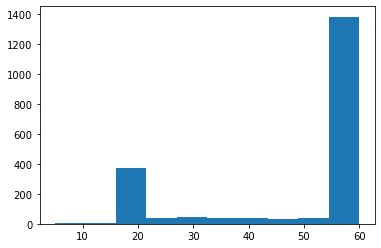

In [419]:
plt.hist(ret_beta.groupby('permno').agg(len)['year']);

(array([2.5000e+01, 0.0000e+00, 1.5000e+01, 0.0000e+00, 3.1000e+01,
        0.0000e+00, 4.9000e+01, 0.0000e+00, 3.6600e+02, 9.8602e+04]),
 array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ]),
 <BarContainer object of 10 artists>)

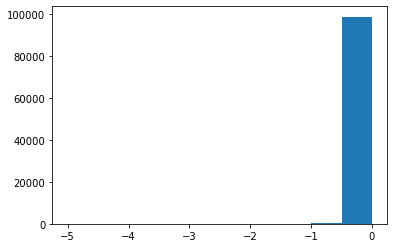

In [420]:
plt.hist(ret_beta.date - ret_beta.max_days)

In [421]:
ret_beta.shape

(99088, 7)

In [422]:
ret_beta = ret_beta.loc[ret_beta.date >= ret_beta.max_days - 5]

In [423]:
ret_beta.shape

(99088, 7)

In [424]:
ret_beta

,permno,year,month,logret,logrm,date,max_days
0,10006,1969,9,0.000001,-0.023250,21,21
1,10014,1969,9,-0.073026,-0.023250,21,21
2,10057,1969,9,-0.016808,-0.023250,21,21
3,10102,1969,9,-0.088194,-0.023250,21,21
4,10137,1969,9,0.014945,-0.023250,21,21
...,...,...,...,...,...,...,...
99665,80945,1974,8,0.065597,-0.091701,22,22
99666,82705,1974,8,-0.104650,-0.091701,22,22
99667,82852,1974,8,-0.092019,-0.091701,22,22
99668,82959,1974,8,-0.252815,-0.091701,22,22


In [426]:
def compute_beta(ret_date, ret_past, ff, tolerance_months=6):
    permnos = ret_date.permno.unique()
    ret_beta = (ret_past \
                    .loc[ret_past.date <= date]
                    .merge(ff[['date', 'logrm']], how='inner', left_on='date', right_on='date')
               )
    ret_beta['year'] = ret_beta.date.dt.year
    ret_beta['month'] = ret_beta.date.dt.month
    ret_beta = (ret_beta \
                    .groupby(['permno', 'year', 'month'])['date', 'logret', 'logrm']
                    .agg({'logret': sum, 'logrm': sum, 'date': len}).reset_index())
    months_max = ret_beta.groupby(['year', 'month'])['date'].max().reset_index().rename(columns={'date': 'max_days'})
    ret_beta = ret_beta.merge(months_max, how='inner', left_on=['year', 'month'], right_on=['year', 'month'])
    ret_beta = ret_beta.loc[ret_beta.date >= ret_beta.max_days - 5]
    months = ret_beta.groupby('permno')['year'].count().max()
    beta = pd.DataFrame(index=ret_date.permno, columns=['beta']).reset_index()
    for permno in permnos:
        beta_df = ret_beta.loc[ret_beta.permno == permno]
        if beta_df.shape[0] >= months - tolerance_months:
            x = beta_df[['logrm']]
            y = beta_df['logret']
            reg = LinearRegression(fit_intercept=False).fit(x, y)
            beta.loc[beta.permno == permno, 'beta'] = reg.coef_[0]
    return beta

In [427]:
beta = compute_beta(ret_date, ret_past, ff)
beta.head()

,permno,beta
0,59395,NaN
1,12490,0.67541
2,10401,0.632882
3,11850,0.458478
4,11754,0.758061


In [428]:
beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   permno  2000 non-null   int64 
 1   beta    1395 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [429]:
beta.tail()

,permno,beta
1995,43887,1.790871
1996,28716,1.333015
1997,35430,0.816967
1998,52513,NaN
1999,29102,0.685044


In [374]:
beta.describe()

,permno
count,1669.000000
mean,32317.457160
std,11423.327843
min,10006.000000
25%,22998.000000
50%,32600.000000
75%,42833.000000
max,68195.000000


##### Everything together

In [9]:
def compute_factor(ret_past, name, target_col, date_start, date_end, operation, tolerance_days):
    factor_past = (ret_past
                   .loc[ret_past.date.between(date_start, date_end)]
                   .groupby('permno').agg({target_col: [operation, len]})
                  )
    factor = factor_past.loc[factor_past.iloc[:, 1] >= factor_past.iloc[:, 1].max() - tolerance_days]
    factor = pd.DataFrame(factor.iloc[:, 0].values, index=factor.index, columns=[name]).reset_index()
    return factor

In [10]:
#def compute_beta(ret_date, ret_past, ff, tolerance_days = 10):
#    permnos = ret_date.permno.unique()
#    if 'logrm' not in ret_past.columns:
#        ret_past = ret_past.merge(ff[['date', 'logrm']], how='inner', left_on='date', right_on='date')
#    days = ret_past.groupby('permno')['date'].count().max()
#    beta = pd.DataFrame(index=ret_date.permno, columns=['beta']).reset_index()
#    for permno in permnos:
#        beta_df = ret_past.loc[ret_past.permno == permno]
#        if beta_df.shape[0] >= days - tolerance_days:
#            x = beta_df[['logrm']]
#            y = beta_df['logret']
#            reg = LinearRegression(fit_intercept=False).fit(x, y)
#            beta.loc[ret_date.permno == permno, 'beta'] = reg.coef_[0]
#    return beta

In [11]:
def compute_beta(ret_date, ret_past, ff, date_end, tolerance_months=6):
    try:
        permnos = ret_date.permno.unique()
        ret_beta = (ret_past \
                        .loc[ret_past.date <= date_end]
                        .merge(ff[['date', 'logrm']], how='inner', left_on='date', right_on='date')
                   )
        ret_beta['year'] = ret_beta.date.dt.year
        ret_beta['month'] = ret_beta.date.dt.month
        ret_beta = (ret_beta \
                        .groupby(['permno', 'year', 'month'])['date', 'logret', 'logrm']
                        .agg({'logret': sum, 'logrm': sum, 'date': len}).reset_index())
        months_max = ret_beta.groupby(['year', 'month'])['date'].max().reset_index().rename(columns={'date': 'max_days'})
        ret_beta = ret_beta.merge(months_max, how='inner', left_on=['year', 'month'], right_on=['year', 'month'])
        ret_beta = ret_beta.loc[ret_beta.date >= ret_beta.max_days - 5]
        #ret_beta = ret_beta.loc[ret_beta['date'] >= 15]
        months = ret_beta.groupby('permno')['year'].count().max()
        beta = pd.DataFrame(index=ret_date.permno, columns=['beta']).reset_index()
        for permno in permnos:
            beta_df = ret_beta.loc[ret_beta.permno == permno, ['logrm', 'logret']].dropna()
            if (beta_df.shape[0] >= months - tolerance_months) and (beta_df.shape[0] > 0):
                x = beta_df[['logrm']]
                y = beta_df['logret']
                reg = LinearRegression(fit_intercept=False).fit(x, y)
                beta.loc[beta.permno == permno, 'beta'] = reg.coef_[0]
        return beta
    except Exception as e:
        exc_type, exc_value, exc_tb = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_tb)        
        print("ff")
        print(ff.head())
        print("ret_past")
        print(ret_past.head())
        print("ret_beta")
        print(ret_beta.head())
        print("beta_df")
        print(beta_df.head())

In [12]:
def compute_factors_date(date, ff):
    
    # Get data for the date
    date_str = date.strftime('%Y-%m-%d')
    query = f"select * from crsp_monthly_returns where date = '{date_str}'"
    ret_date = sql.select_query(query)
    ret_date['logret'] = np.log(1 + ret_date.ret)

    # Relevant past dates    
    date_5y = date - relativedelta(years=5)
    date_12m = date - relativedelta(months=12)
    date_1m = date - relativedelta(months=1)
    date_f1m = date + relativedelta(months=1)
    date_str = date.strftime('%Y-%m-%d')
    date_f1m_str = date_f1m.strftime('%Y-%m-%d')
    date_5y_str = date_5y.strftime('%Y-%m-%d')

    # Past data of relevant permnos
    query = rf"""
    select * from crsp_returns 
    where date between '{date_5y_str}' and '{date_f1m_str}'
          and permno in ({','.join([str(permno) for permno in ret_date.permno])})
    """
    ret_past = sql.select_query(query)
    ret_past['logret'] = np.log(1 + ret_past.ret)
    
    # Next month log return
    logret = compute_factor(ret_past, 'logret_1m', 'logret', date + relativedelta(days=1), date_f1m, np.sum, 2)
    ret_date = ret_date.merge(logret, how='left', left_on='permno', right_on='permno')

    # Beta
    beta = compute_beta(ret_date, ret_past, ff, date)
    ret_date = ret_date.merge(beta, how='left', left_on='permno', right_on='permno')
    
    # Momentum
    mom = compute_factor(ret_past, 'mom', 'logret', date_12m, date_1m, sum, 5)
    ret_date = ret_date.merge(mom, how='left', left_on='permno', right_on='permno')

    # Volatility
    vol = compute_factor(ret_past, 'vol', 'logret', date_5y, date, np.std, 10)
    ret_date = ret_date.merge(vol, how='left', left_on='permno', right_on='permno')

    # Upload
    cols = ['permno', 'date', 'ticker', 'logret', 'logret_1m', 'beta', 'bm', 'size', 'mom', 'vol']    
    sql.upload_df_chunks('crsp_monthly_returns_factors', ret_date[cols], chunk_size=100)

In [13]:
def compute_factors(clean_table=True, date_start=None):
    
    # Clean table
    if clean_table:
        sql.clean_table('crsp_monthly_returns_factors')
    
    # Dates
    query = f"select distinct date from crsp_monthly_returns order by date"
    dates = sql.select_query(query).date
    if date_start is not None:
        dates = dates.loc[dates >= date_start]
    
    # Fama-French (for market returns)
    ff = pd.read_csv("data/ff_daily.csv", skiprows=4).dropna()
    ff.columns = ['date', 'rm-rf', 'smb', 'hml', 'rf']
    ff['logrm'] = np.log(1 + (ff['rm-rf']+ff['rf'])/100)
    ff['date'] = pd.to_datetime(ff.date, format="%Y%m%d")
    
    # Compute factor for each date
    for date in dates:
        print(date.strftime('%Y-%m-%d'), end="\r")
        compute_factors_date(date, ff)

In [14]:
if True:
    compute_factors(clean_table=False, date_start=datetime(2011, 9, 1))

In [45]:
sql.select_query('select * from crsp_monthly_returns_factors limit 100')

,permno,date,ticker,logret,logret_1m,beta,bm,size,mom,vol
0,12490,1970-08-31,IBM,-0.018605,0.091459,0.873784,0.129,30277418,-0.298030,0.013239
1,10401,1970-08-31,T,0.002713,-0.019150,0.604153,0.904,25334802,-0.078540,0.010114
2,12079,1970-08-31,GM,0.000000,-0.022280,0.945850,0.510,21075021,-0.018907,0.011899
3,11850,1970-08-31,J,-0.003788,0.016931,0.626259,0.797,14733800,-0.109468,0.011167
4,11754,1970-08-31,EK,0.007752,0.011516,0.785333,0.157,10460039,-0.175074,0.013754
...,...,...,...,...,...,...,...,...,...,...
95,21450,1970-08-31,SOH,0.001899,0.042719,0.818577,0.647,871460,-0.593309,0.017350
96,20482,1970-08-31,ABT,0.000000,0.086344,0.569543,0.221,841564,-0.089359,0.014886
97,34833,1970-08-31,OXY,-0.022141,0.180139,1.672053,0.209,840800,-0.723401,0.028586
98,21792,1970-08-31,HOU,-0.011976,-0.015173,0.851771,0.434,840458,0.089301,0.016233


## Data download for assignment

In [123]:
df = sql.select_query('select * from crsp_monthly_returns_factors')

In [124]:
# From log-returns to returns
df['logret'] = np.exp(df['logret']) - 1
df['logret_1m'] = np.exp(df['logret_1m']) - 1
df.rename(columns={'logret': 'ret', 'logret_1m': 'ret_1m'}, inplace=True)

In [125]:
df.head()

,permno,date,ticker,ret,ret_1m,beta,bm,size,mom,vol
0,12490,1970-02-27,IBM,-0.011619,-0.020571,0.850435,0.130,38692550,0.153744,0.011998
1,10401,1970-02-27,T,0.012346,0.036585,0.499055,0.797,28149780,-0.036718,0.009550
2,12079,1970-02-27,GM,0.012774,0.088290,0.988987,0.424,19824808,-0.112489,0.011287
3,11754,1970-02-27,EK,0.017516,-0.010956,0.895631,0.158,12903407,0.152501,0.012766
4,11850,1970-02-27,J,-0.002309,0.062500,0.583836,0.608,12077802,-0.214943,0.010576


In [126]:
ff = pd.read_csv("data/ff_daily.csv", skiprows=4).dropna()
ff.columns = ['date', 'rm-rf', 'smb', 'hml', 'rf']
ff['logrm'] = np.log(1 + (ff['rm-rf']+ff['rf'])/100)
ff['date'] = pd.to_datetime(ff.date, format="%Y%m%d")

In [127]:
ff.head()

,date,rm-rf,smb,hml,rf,logrm
0,1926-07-01,0.10,-0.23,-0.28,0.009,0.001089
1,1926-07-02,0.45,-0.34,-0.03,0.009,0.004579
2,1926-07-06,0.17,0.29,-0.38,0.009,0.001788
3,1926-07-07,0.09,-0.59,0.00,0.009,0.000990
4,1926-07-08,0.21,-0.38,0.18,0.009,0.002188


In [128]:
rf_year = np.exp(np.log(ff['rf']/100+1)*252) - 1

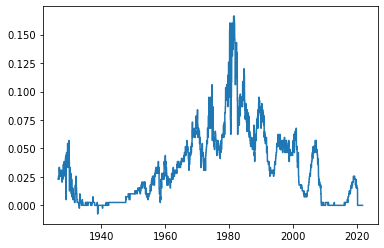

In [129]:
plt.plot(ff.date, rf_year);

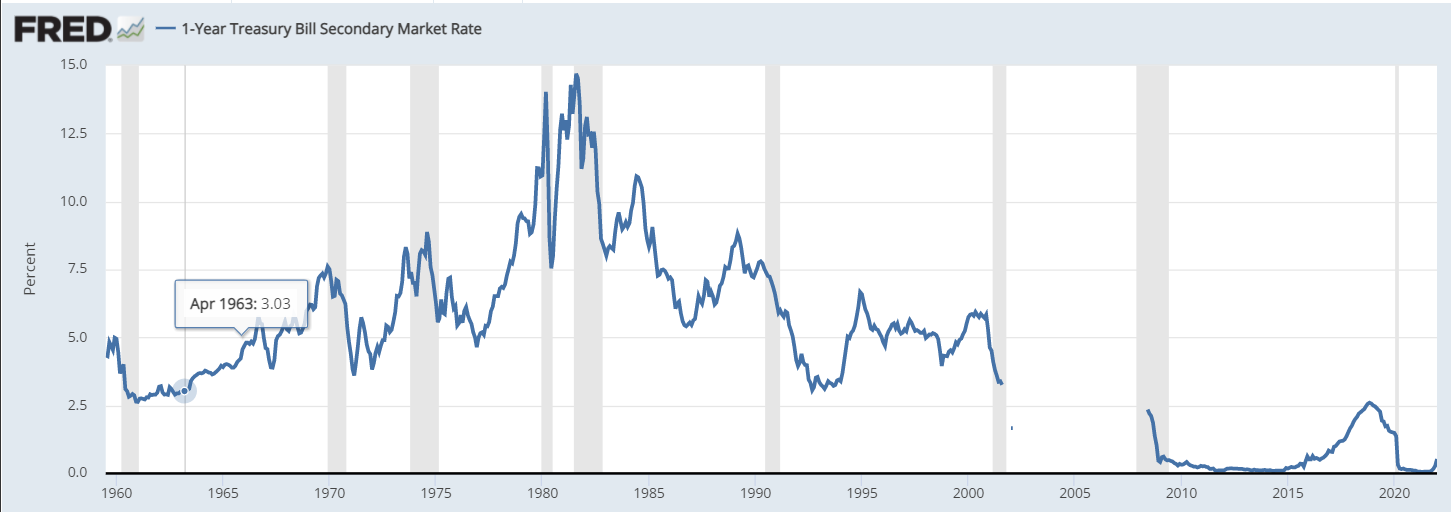

In [130]:
year = ff.date.dt.year
month = ff.date.dt.month
year.name = 'year'
month.name = 'month'
bd = ff.groupby([year, month]).agg({'rm-rf': 'count', 'date': 'last', 'rf': 'last'}).reset_index()
bd.rename(columns={'rm-rf': 'count'}, inplace=True)
bd['bdays_next_month'] = bd['count'].shift(-1)
bd

,year,month,count,date,rf,bdays_next_month
0,1926,7,25,1926-07-31,0.009,26.0
1,1926,8,26,1926-08-31,0.010,24.0
2,1926,9,24,1926-09-30,0.009,25.0
3,1926,10,25,1926-10-30,0.013,24.0
4,1926,11,24,1926-11-30,0.013,26.0
...,...,...,...,...,...,...
1139,2021,6,22,2021-06-30,0.000,21.0
1140,2021,7,21,2021-07-30,0.000,22.0
1141,2021,8,22,2021-08-31,0.000,21.0
1142,2021,9,21,2021-09-30,0.000,21.0


In [131]:
bd['rf_next_month'] = np.exp(np.log(1 + bd.rf/100)*bd.bdays_next_month) - 1

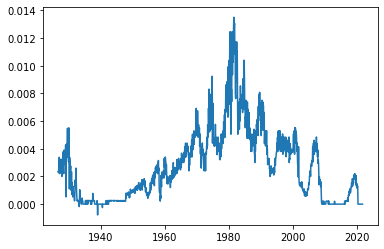

In [132]:
plt.plot(bd.date, bd['rf_next_month'])

In [133]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
out = df.merge(bd[['year', 'month', 'rf_next_month']], how='left', left_on=['year', 'month'], right_on=['year', 'month'])
out = out.drop(columns=['year', 'month'])

In [134]:
out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217812 entries, 0 to 1217811
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   permno         1217812 non-null  int64         
 1   date           1217812 non-null  datetime64[ns]
 2   ticker         1216518 non-null  object        
 3   ret            1217812 non-null  float64       
 4   ret_1m         1211437 non-null  float64       
 5   beta           988442 non-null   float64       
 6   bm             1217812 non-null  float64       
 7   size           1217812 non-null  int64         
 8   mom            1175578 non-null  float64       
 9   vol            965218 non-null   float64       
 10  rf_next_month  1217812 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 111.5+ MB


In [138]:
out.rename(columns={'rf_next_month': 'rf'}, inplace=True)

In [139]:
out.head()

,permno,date,ticker,ret,ret_1m,beta,bm,size,mom,vol,rf
0,12490,1970-02-27,IBM,-0.011619,-0.020571,0.850435,0.130,38692550,0.153744,0.011998,0.006742
1,10401,1970-02-27,T,0.012346,0.036585,0.499055,0.797,28149780,-0.036718,0.009550,0.006742
2,12079,1970-02-27,GM,0.012774,0.088290,0.988987,0.424,19824808,-0.112489,0.011287,0.006742
3,11754,1970-02-27,EK,0.017516,-0.010956,0.895631,0.158,12903407,0.152501,0.012766,0.006742
4,11850,1970-02-27,J,-0.002309,0.062500,0.583836,0.608,12077802,-0.214943,0.010576,0.006742


In [140]:
out = out.sort_values(by=['date', 'size'], ascending=[True, False])

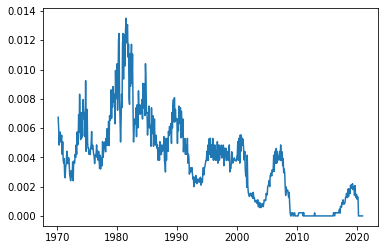

In [142]:
# Sanity check
plt.plot(out.date, out.rf)

<AxesSubplot:xlabel='date'>

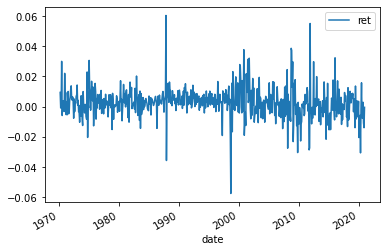

In [146]:
# Sanity check
out.groupby('date')[['ret']].mean().plot()

In [147]:
filename = f"data/crsp_returns_factors.csv"
out.to_csv(filename)

## Annex

In [ ]:
crsp_daily = pd.DataFrame(
[['cusip', 'string', 'Cusip (cusip)'],
['ncusip', 'string', 'Ncusip (ncusip)'],
['comnam', 'string', 'Company Name (comnam)'],
['ticker', 'string', 'Ticker (ticker)'],
['permco', 'double', 'CRSP Permanent Company Number (permco)'],
['shrcd', 'double', 'Share Code (shrcd)'],
['shrcls', 'string', 'Share Class (shrcls)'],
['issuno', 'double', 'Nasdaq Issue Number (issuno)'],
['exchcd', 'double', 'Exchange Code (exchcd)'],
['hexcd', 'double', 'Header Exchange Code (hexcd)'],
['siccd', 'double', 'SIC Code (siccd)'],
['hsiccd', 'double', 'Header SIC Code (hsiccd)'],
['hsicmg', 'double', 'Header SIC Major Group (hsicmg)'],
['hsicig', 'double', 'Header SIC Industry Group (hsicig)'],
['nameendt', 'date', 'Names Ending Date (nameendt)'],
['tsymbol', 'string', 'Trading Symbol (tsymbol)'],
['naics', 'string', 'North American Industry Class System (naics)'],
['primexch', 'string', 'Primary Exchange (primexch)'],
['trdstat', 'string', 'Trading Status (trdstat)'],
['secstat', 'string', 'Security Status (secstat)'],
['prc', 'double', 'Price (prc)'],
['vol', 'double', 'Share Volume (vol)'],
['openprc', 'double', 'Open Price (openprc)'],
['askhi', 'double', 'Ask or High (askhi)'],
['bidlo', 'double', 'Bid or Low (bidlo)'],
['bid', 'double', 'Closing Bid (bid)'],
['ask', 'double', 'Closing Ask (ask)'],
['numtrd', 'double', 'Number of Trades (numtrd)'],
['ret', 'double', 'Holding Period Return (ret)'],
['retx', 'double', 'Return without Dividends (retx)'],
['shrout', 'double', 'Number of Shares Outstanding (shrout)'],
['shrflg', 'double', 'Share Flag (shrflg)'],
['shrenddt', 'date', 'Shares Observation End Date (shrenddt)'],
['dlstcd', 'double', 'Delisting Code (dlstcd)'],
['nwperm', 'double', 'New CRSP Permno (nwperm)'],
['nextdt', 'date', 'Date of Next Available Information (nextdt)'],
['dlamt', 'double', 'Amount After Delisting (dlamt)'],
['dlprc', 'double', 'Delisting Price (dlprc)'],
['dlpdt', 'date', 'Date of Delisting Payment (dlpdt)'],
['dlret', 'double', 'Delisting Return (dlret)'],
['dlretx', 'double', 'Delisting Return without Dividends (dlretx)'],
['distcd', 'double', 'Distribution Code (distcd)'],
['divamt', 'double', 'Dividend Cash Amount (divamt)'],
['facpr', 'double', 'Factor to Adjust Price (facpr)'],
['facshr', 'double', 'Factor to Adjust Shares (facshr)'],
['cfacpr', 'double', 'Cumulative Factor to Adjust Price (cfacpr)'],
['cfacshr', 'double', 'Cumulative Factor to Adjust Shares (cfacshr)'],
['dclrdt', 'date', 'Declaration Date (dclrdt)'],
['rcrddt', 'date', 'Record Date (rcrddt)'],
['paydt', 'date', 'Payment Date (paydt)'],
['acperm', 'double', 'Acquiring PERMNO (acperm)'],
['accomp', 'double', 'Acquiring PERMCO (accomp)'],
['trtscd', 'double', 'Traits Code (trtscd)'],
['nmsind', 'double', 'National Market Indicator (nmsind)'],
['mmcnt', 'double', 'Market Maker Count (mmcnt)'],
['nsdinx', 'double', 'NASD Index (nsdinx)'],
['vwretd', 'double', 'Value-Weighted Return (includes distributions) (vwretd)'],
['vwretx', 'double', 'Value-Weighted Return (excluding dividends) (vwretx)'],
['ewretd', 'double', 'Equal-Weighted Return (includes distributions) (ewretd)'],
['ewretx', 'double', 'Equal-Weighted Return (excluding dividends) (ewretx)'],
['sprtrn', 'double', 'Return on S&P Composite Index (sprtrn)']],
columns = ['Variable Name', 'Type', 'Description'])
#crsp_daily.to_markdown()

In [ ]:
wrds_ratio = pd.DataFrame(
[["PERMNO", "double", "PERMNO (PERMNO)"],
["GVKEY", "string", "Global Company Key (GVKEY)"],
["CUSIP", "string", "CUSIP IDENTIFIER - HISTORICAL (CUSIP)"],
["TICKER", "string", "EXCHANGE TICKER SYMBOL - HISTORICAL (TICKER)"],
["dpr", "double", "Dividend Payout Ratio (dpr)"],
["PEG_trailing", "double", "Trailing P/E to Growth (PEG) ratio (PEG_trailing)"],
["bm", "double", "Book/Market (bm)"],
["capei", "double", "Shillers Cyclically Adjusted P/E Ratio (capei)"],
["divyield", "double", "Dividend Yield (divyield)"],
["evm", "double", "Enterprise Value Multiple (evm)"],
["pcf", "double", "Price/Cash flow (pcf)"],
["pe_exi", "double", "P/E (Diluted, Excl. EI) (pe_exi)"],
["pe_inc", "double", "P/E (Diluted, Incl. EI) (pe_inc)"],
["pe_op_basic", "double", "Price/Operating Earnings (Basic, Excl. EI) (pe_op_basic)"],
["pe_op_dil", "double", "Price/Operating Earnings (Diluted, Excl. EI) (pe_op_dil)"],
["ps", "double", "Price/Sales (ps)"],
["ptb", "double", "Price/Book (ptb)"],
["efftax", "double", "Effective Tax Rate (efftax)"],
["GProf", "double", "Gross Profit/Total Assets (GProf)"],
["aftret_eq", "double", "After-tax Return on Average Common Equity (aftret_eq)"],
["aftret_equity", "double", "After-tax Return on Total Stockholders Equity (aftret_equity)"],
["aftret_invcapx", "double", "After-tax Return on Invested Capital (aftret_invcapx)"],
["gpm", "double", "Gross Profit Margin (gpm)"],
["npm", "double", "Net Profit Margin (npm)"],
["opmad", "double", "Operating Profit Margin After Depreciation (opmad)"],
["opmbd", "double", "Operating Profit Margin Before Depreciation (opmbd)"],
["pretret_earnat", "double", "Pre-tax Return on Total Earning Assets (pretret_earnat)"],
["pretret_noa", "double", "Pre-tax return on Net Operating Assets (pretret_noa)"],
["ptpm", "double", "Pre-tax Profit Margin (ptpm)"],
["roa", "double", "Return on Assets (roa)"],
["roce", "double", "Return on Capital Employed (roce)"],
["roe", "double", "Return on Equity (roe)"],
["capital_ratio", "double", "Capitalization Ratio (capital_ratio)"],
["equity_invcap", "double", "Common Equity/Invested Capital (equity_invcap)"],
["debt_invcap", "double", "Long-term Debt/Invested Capital (debt_invcap)"],
["totdebt_invcap", "double", "Total Debt/Invested Capital (totdebt_invcap)"],
["invt_act", "double", "Inventory/Current Assets (invt_act)"],
["rect_act", "double", "Receivables/Current Assets (rect_act)"],
["fcf_ocf", "double", "Free Cash Flow/Operating Cash Flow (fcf_ocf)"],
["ocf_lct", "double", "Operating CF/Current Liabilities (ocf_lct)"],
["cash_debt", "double", "Cash Flow/Total Debt (cash_debt)"],
["cash_lt", "double", "Cash Balance/Total Liabilities (cash_lt)"],
["cfm", "double", "Cash Flow Margin (cfm)"],
["short_debt", "double", "Short-Term Debt/Total Debt (short_debt)"],
["profit_lct", "double", "Profit Before Depreciation/Current Liabilities (profit_lct)"],
["curr_debt", "double", "Current Liabilities/Total Liabilities (curr_debt)"],
["debt_ebitda", "double", "Total Debt/EBITDA (debt_ebitda)"],
["dltt_be", "double", "Long-term Debt/Book Equity (dltt_be)"],
["int_debt", "double", "Interest/Average Long-term Debt (int_debt)"],
["int_totdebt", "double", "Interest/Average Total Debt (int_totdebt)"],
["lt_debt", "double", "Long-term Debt/Total Liabilities (lt_debt)"],
["lt_ppent", "double", "Total Liabilities/Total Tangible Assets (lt_ppent)"],
["de_ratio", "double", "Total Debt/Equity (de_ratio)"],
["debt_assets", "double", "Total Debt/Total Assets (debt_assets)"],
["debt_at", "double", "Total Debt/Total Assets (debt_at)"],
["debt_capital", "double", "Total Debt/Capital (debt_capital)"],
["intcov", "double", "After-tax Interest Coverage (intcov)"],
["intcov_ratio", "double", "Interest Coverage Ratio (intcov_ratio)"],
["cash_conversion", "double", "Cash Conversion Cycle (Days) (cash_conversion)"],
["cash_ratio", "double", "Cash Ratio (cash_ratio)"],
["curr_ratio", "double", "Current Ratio (curr_ratio)"],
["quick_ratio", "double", "Quick Ratio (Acid Test) (quick_ratio)"],
["at_turn", "double", "Asset Turnover (at_turn)"],
["inv_turn", "double", "Inventory Turnover (inv_turn)"],
["pay_turn", "double", "Payables Turnover (pay_turn)"],
["rect_turn", "double", "Receivables Turnover (rect_turn)"],
["sale_equity", "double", "Sales/Stockholders Equity (sale_equity)"],
["sale_invcap", "double", "Sales/Invested Capital (sale_invcap)"],
["sale_nwc", "double", "Sales/Working Capital (sale_nwc)"],
["Accrual", "double", "Accruals/Average Assets (Accrual)"],
["RD_SALE", "double", "Research and Development/Sales (RD_SALE)"],
["adv_sale", "double", "Avertising Expenses/Sales (adv_sale)"],
["staff_sale", "double", "Labor Expenses/Sales (staff_sale)"]],
columns=["Variable Name", "Type", "Description"])